## Raster图、PSTH图、Tuning Curve

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_path = './dataset/indy_20161005_06.mat'
data = h5py.File(data_path)

In [3]:
for key in data.keys():
    print(data[key])

<HDF5 group "/#refs#" (1057 members)>
<HDF5 dataset "chan_names": shape (1, 96), type "|O">
<HDF5 dataset "cursor_pos": shape (2, 93501), type "<f8">
<HDF5 dataset "finger_pos": shape (3, 93501), type "<f8">
<HDF5 dataset "spikes": shape (5, 96), type "|O">
<HDF5 dataset "t": shape (1, 93501), type "<f8">
<HDF5 dataset "target_pos": shape (2, 93501), type "<f8">
<HDF5 dataset "wf": shape (5, 96), type "|O">


In [4]:
# convert hdf5 object to np.ndarray
cursor_pos = np.array(data['cursor_pos']).transpose(1, 0)
finger_pos = np.array(data['finger_pos']).transpose(1, 0)
target_pos = np.array(data['target_pos']).transpose(1, 0)
t = np.array(data['t']).transpose(1, 0)

print(cursor_pos.shape)
print(finger_pos.shape)
print(target_pos.shape)
print(t.shape)

(93501, 2)
(93501, 3)
(93501, 2)
(93501, 1)


In [5]:
# compute the time where a target conversion happens
event_point = []
event_index = []
for i in range(t.shape[0] - 1):
    if (target_pos[i+1] != target_pos[i]).all():
        event_point.append(t[i+1])
        event_index.append(i+1)
event_point = np.array(event_point)
event_index = np.array(event_index)

In [6]:
# compute v, a
v = (cursor_pos[1:, :] - cursor_pos[:-1, :]) / (t[1:] - t[:-1])
a = (v[1:, :] - v[:-1, :]) / (t[1:-1] - t[:-2])

print(v.shape)
print(a.shape)

(93500, 2)
(93499, 2)


In [7]:
unit_num = data['spikes'].shape[0]
channel_num = data['spikes'].shape[1]

for channel_id in range(0, channel_num):
    # omit unsorted neurons
    for unit_id in range(1, unit_num):
        try:
            spikes = spikes = np.array(data[data['spikes'][unit_id, channel_id]]).transpose(1, 0)
            print(f"Find sorted neuron in ({unit_id}, {channel_id}), spikes shape: {spikes.shape}")
        except:
            print(f"No sorted neuron in   ({unit_id}, {channel_id})")

Find sorted neuron in (1, 0), spikes shape: (6, 1)
Find sorted neuron in (2, 0), spikes shape: (1078, 1)
No sorted neuron in   (3, 0)
No sorted neuron in   (4, 0)
Find sorted neuron in (1, 1), spikes shape: (1914, 1)
Find sorted neuron in (2, 1), spikes shape: (434, 1)
Find sorted neuron in (3, 1), spikes shape: (1180, 1)
Find sorted neuron in (4, 1), spikes shape: (366, 1)
Find sorted neuron in (1, 2), spikes shape: (1292, 1)
No sorted neuron in   (2, 2)
No sorted neuron in   (3, 2)
No sorted neuron in   (4, 2)
No sorted neuron in   (1, 3)
Find sorted neuron in (2, 3), spikes shape: (241, 1)
Find sorted neuron in (3, 3), spikes shape: (2349, 1)
No sorted neuron in   (4, 3)
Find sorted neuron in (1, 4), spikes shape: (919, 1)
No sorted neuron in   (2, 4)
No sorted neuron in   (3, 4)
No sorted neuron in   (4, 4)
Find sorted neuron in (1, 5), spikes shape: (571, 1)
No sorted neuron in   (2, 5)
No sorted neuron in   (3, 5)
No sorted neuron in   (4, 5)
Find sorted neuron in (1, 6), spikes 

In [9]:
unit_id = 1
# channel_id = 94
channel_id = 34

spikes = np.array(data[data['spikes'][unit_id, channel_id]]).transpose(1, 0)
print(spikes.shape)

(1352, 1)


我们需要做什么？

想法，根据某种指标找到一系列trial，然后绘制

一系列trial的特点？

- 速度方向
- 速度大小
- 加速度方向
- 加速度大小

感觉位置的意义不大？

In [10]:
def extract_spikes(spikes, event_t, range=[-0.5, 1.2]):
    extracted_spk = []

    for spike in spikes:
        if spike > event_t + range[0] and spike < event_t + range[1]:
            extracted_spk.append(spike)
        
    return np.array(extracted_spk)

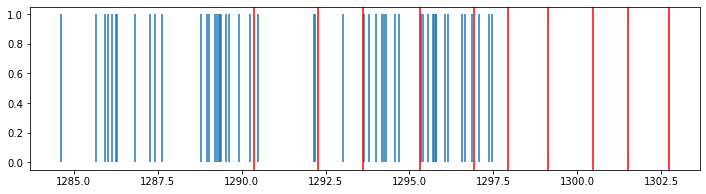

In [11]:
plt.figure(figsize=(12, 3))
plt.vlines(spikes[0:50], ymin=0, ymax=1)
for i in range(10):
    # print(i)
    plt.axvline(x = event_point[i], color='red')
    # print(target_pos[event_index[i]] - target_pos[event_index[i] - 1])
    # print(v[event_index[i] + 10])
    # print(cursor_pos[event_index[i+1]] - cursor_pos[event_index[i]])
plt.show()

In [12]:
# 统计每个时间段内的发放次数
firing_count = [0 for _ in range(len(event_point) - 1)]
event_cnt = 0

for i in range(len(spikes)):
    if spikes[i, 0] < event_point[event_cnt]:
        continue
    while spikes[i, 0] > event_point[event_cnt + 1] and event_cnt < len(event_point) - 2:
        event_cnt += 1
    if event_cnt >= len(event_point) - 1:
        break
    firing_count[event_cnt] += 1

firing_count = np.array(firing_count)
firing_rate  = firing_count / (event_point[1:, 0] - event_point[:-1, 0])

In [13]:
def compute_degree(vector):
    """返回一个二维向量与x轴的夹角大小"""
    if vector[1] > 0:
        return np.arccos(vector[0] / np.linalg.norm(vector)) / np.pi * 180
    else:
        return 360 - np.arccos(vector[0] / np.linalg.norm(vector)) / np.pi * 180

In [14]:
unit_id = 2
channel_id = 79

spikes = np.array(data[data['spikes'][unit_id, channel_id]]).transpose(1, 0)
print(spikes.shape)

(2130, 1)


In [15]:
# 统计每个时间段内的发放次数
firing_count = [0 for _ in range(len(event_point) - 1)]
event_cnt = 0

for i in range(len(spikes)):
    if spikes[i, 0] < event_point[event_cnt]:
        continue
    while spikes[i, 0] > event_point[event_cnt + 1] and event_cnt < len(event_point) - 2:
        event_cnt += 1
    if event_cnt >= len(event_point) - 1:
        break
    firing_count[event_cnt] += 1

firing_count = np.array(firing_count)
firing_rate  = firing_count / (event_point[1:, 0] - event_point[:-1, 0])

{0: [3, 16, 32, 33, 36, 39, 52, 69, 78, 101, 104, 109, 111, 113, 132, 140, 152, 161, 166, 178, 184, 187, 192, 201, 215], 45: [19, 26, 27, 43, 45, 48, 50, 56, 64, 76, 81, 88, 92, 94, 95, 102, 106, 115, 121, 124, 130, 135, 143, 149, 155, 163, 171, 174, 176, 207, 210, 217, 220, 224, 230], 90: [2, 8, 12, 15, 21, 30, 54, 61, 77, 89, 99, 118, 126, 145, 151, 157, 194, 197, 205, 213, 222, 226], 135: [4, 6, 10, 17, 37, 40, 59, 63, 66, 70, 72, 74, 80, 85, 91, 98, 108, 127, 131, 137, 160, 169, 179, 181, 185, 186, 188, 191, 198, 199, 203, 219, 229], 180: [11, 20, 24, 25, 28, 42, 47, 51, 68, 82, 87, 103, 112, 117, 122, 134, 139, 141, 148, 154, 158, 165, 172, 177, 202, 212, 228], 225: [1, 14, 18, 22, 29, 31, 34, 38, 44, 46, 53, 55, 57, 75, 79, 90, 93, 105, 110, 116, 120, 125, 133, 144, 150, 162, 167, 173, 175, 183, 193, 206, 208, 209, 214, 216, 218, 225], 270: [5, 9, 41, 60, 67, 71, 84, 97, 107, 136, 146, 180, 189, 200, 204, 211, 223], 315: [0, 7, 13, 23, 35, 49, 58, 62, 65, 73, 83, 86, 96, 100, 114

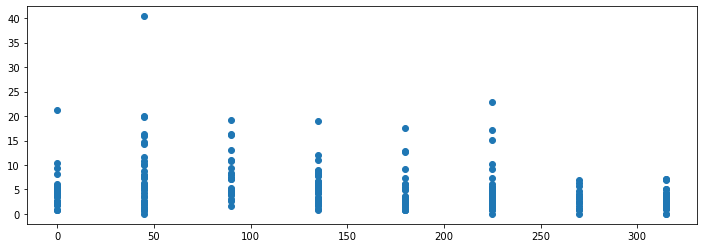

In [16]:
degree = []
firing = []
speed  = []
degree_index = {
    k: [] for k in range(0, 360, 45)
}

for i in range(len(event_point) - 1):
    # 对所有事件循环，计算一段时间的位移方向
    pos_diff = cursor_pos[event_index[i+1]] - cursor_pos[event_index[i]]
    # pos_diff = target_pos[event_index[i]] - target_pos[event_index[i] - 1]
    d = int(np.floor(compute_degree(pos_diff) / 45 + 0.5) * 45)
    if d == 360:
        d = 0
    degree.append(d)
    # 计算这段区间内的Firing Rate
    firing.append(firing_rate[i])
    speed.append(pos_diff / (event_point[i+1] - event_point[i]))
    degree_index[d].append(i)

print(degree_index)

plt.figure(figsize=(12, 4))
plt.scatter(degree, firing)
plt.show()

[-2.18741653  0.01654102  1.71579513  5.28400394]


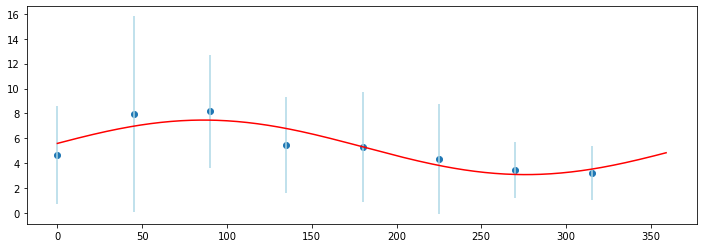

In [17]:
degree_fire = {}
for i in range(len(event_point) - 1):
    # 对所有事件循环，计算一段时间的位移方向
    # pos_diff = cursor_pos[event_index[i+1]] - cursor_pos[event_index[i]]
    pos_diff = target_pos[event_index[i]] - target_pos[event_index[i] - 1]
    degree = int(np.floor(compute_degree(pos_diff) / 45 + 0.5)) * 45
    if degree == 360:
        degree = 0

    # 计算这段区间内的Firing Rate
    tmp = degree_fire.get(degree, [])
    tmp.append(firing_rate[i])
    degree_fire[degree] = tmp

x = []
y = []
std = []
for degree in degree_fire:
    x.append(degree)
    y.append(np.mean(degree_fire[degree]))
    std.append(np.std(degree_fire[degree]))

x = np.array(x)
y = np.array(y)
std = np.array(std)

import scipy.optimize as optimize
pi = np.pi

def target_func(x, a0, a1, a2, a3):
    return a0 * np.cos(a1 * x + a2) + a3

plt.figure(figsize=(12, 4))

# 拟合sin曲线
x_ = np.arange(0, 360)
fs = np.fft.fftfreq(len(x), x[1] - x[0])
Y = abs(np.fft.fft(y))
freq = abs(fs[np.argmax(Y[1:]) + 1])
a0 = max(y) - min(y)
a1 = 2 * pi * freq
a2 = 0
a3 = np.mean(y)
p0 = [a0, a1, a2, a3]
para, _ = optimize.curve_fit(target_func, x, y, p0=p0)
print(para)
y_fit = [target_func(a, *para) for a in x_]
plt.plot(x_, y_fit, 'red')

plt.vlines(x, y-std, y+std, colors='lightblue')
plt.scatter(x, y)

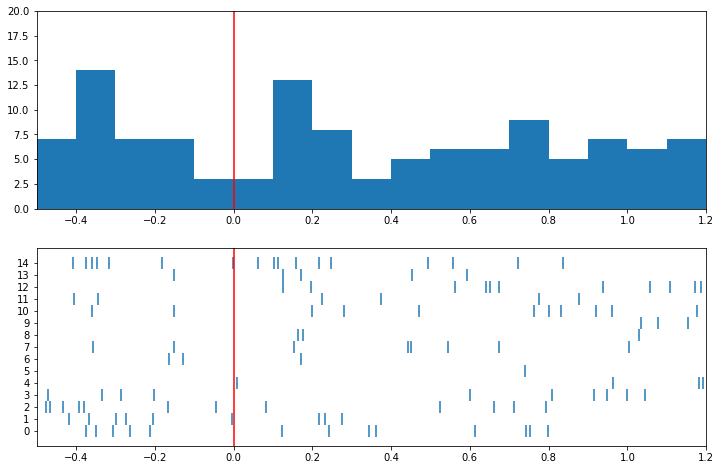

In [18]:
d = 0

plt.figure(figsize=(12, 8))

plt.subplot(212)
total = []
for i in range(15):
    spike_t = extract_spikes(spikes, event_point[degree_index[d][i]]) - event_point[degree_index[d][i]]
    total += spike_t.tolist()
    plt.vlines(spike_t, ymin=i*0.1, ymax=i*0.1+0.1)
plt.axvline(x = 0, color='red')
plt.yticks(ticks=[i*0.1 + 0.05 for i in range(15)], labels=[i for i in range(15)])
plt.xlim(-0.5, 1.2)

plt.subplot(211)
plt.hist(np.array(total), bins=17, range=(-0.5, 1.2))
plt.axvline(x = 0, color='red')
# plt.yticks([])
plt.xlim(-0.5, 1.2)
plt.ylim(0, 20)

plt.show()

## 神经元对运动编码的拟合程度分析

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [20]:
firing = []
speed  = []

unit_id = 1
# channel_id = 94
channel_id = 34

spikes = np.array(data[data['spikes'][unit_id, channel_id]]).transpose(1, 0)
print(spikes.shape)

# 统计每个时间段内的发放次数
firing_count = [0 for _ in range(len(event_point) - 1)]
event_cnt = 0

for i in range(len(spikes)):
    if spikes[i, 0] < event_point[event_cnt]:
        continue
    while spikes[i, 0] > event_point[event_cnt + 1] and event_cnt < len(event_point) - 2:
        event_cnt += 1
    if event_cnt >= len(event_point) - 1:
        break
    firing_count[event_cnt] += 1

firing_count = np.array(firing_count)
firing_rate  = firing_count / (event_point[1:, 0] - event_point[:-1, 0])

for i in range(len(event_point) - 1):
    # 对所有事件循环，计算一段时间的平均速度
    pos_diff = target_pos[event_index[i]] - target_pos[event_index[i] - 1]
    speed.append(pos_diff / (event_point[i+1] - event_point[i]))
    # 计算这段区间内的Firing Rate
    firing.append(firing_rate[i])

speed = np.array(speed)
firing = np.array(firing)

print(speed.shape)

model = LinearRegression()

model.fit(speed, firing)
firing_pred = model.predict(speed)

print(r2_score(firing, firing_pred))

(1352, 1)
(231, 2)
0.17859487555940634


In [21]:
print(model.coef_)
print(model.intercept_)

[-0.00464952  0.02545705]
3.653083827250038


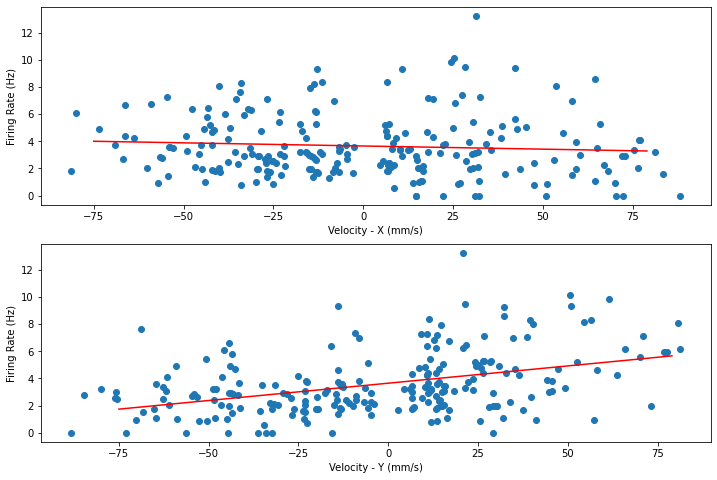

In [22]:
plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.scatter(speed[:, 0], firing)
x = np.arange(-75, 80, 1)
y = model.coef_[0] * x + model.intercept_
plt.plot(x, y, color='red')
plt.xlabel('Velocity - X (mm/s)')
plt.ylabel('Firing Rate (Hz)')

plt.subplot(212)
plt.scatter(speed[:, 1], firing)
x = np.arange(-75, 80, 1)
y = model.coef_[1] * x + model.intercept_
plt.plot(x, y, color='red')
plt.xlabel('Velocity - Y (mm/s)')
plt.ylabel('Firing Rate (Hz)')
plt.show()

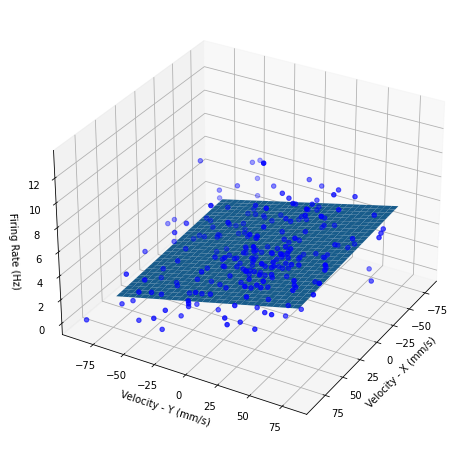

In [23]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
import numpy as np
import random

# dummy variables for demonstration
x = np.arange(-75, 75, 5)
y = np.arange(-75, 75, 5)
X, Y = np.meshgrid(x, y)
Z = model.coef_[0] * X + model.coef_[1] * Y + model.intercept_

# build the figure instance
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
ax.scatter(speed[:, 0], speed[:, 1], firing, c='blue', marker='o')

# set your labels
ax.set_xlabel('Velocity - X (mm/s)')
ax.set_ylabel('Velocity - Y (mm/s)')
ax.set_zlabel('Firing Rate (Hz)')

ax.view_init(
    elev=30,    # 仰角
    azim=30     # 方位角
)

plt.show()

In [24]:
unit_num = data['spikes'].shape[0]
channel_num = data['spikes'].shape[1]

r2_dict = {}
weight_dict = {}

for channel_id in range(0, channel_num):
    # omit unsorted neurons
    for unit_id in range(1, unit_num):
        try:

            firing = []
            speed  = []

            spikes = np.array(data[data['spikes'][unit_id, channel_id]]).transpose(1, 0)

            # 统计每个时间段内的发放次数
            firing_count = [0 for _ in range(len(event_point) - 1)]
            event_cnt = 0

            for i in range(len(spikes)):
                if spikes[i, 0] < event_point[event_cnt]:
                    continue
                while spikes[i, 0] > event_point[event_cnt + 1] and event_cnt < len(event_point) - 2:
                    event_cnt += 1
                if event_cnt >= len(event_point) - 1:
                    break
                firing_count[event_cnt] += 1

            firing_count = np.array(firing_count)
            firing_rate  = firing_count / (event_point[1:, 0] - event_point[:-1, 0])

            for i in range(len(event_point) - 1):
                # 对所有事件循环，计算一段时间的平均速度
                pos_diff = target_pos[event_index[i]] - target_pos[event_index[i] - 1]
                speed.append(pos_diff / (event_point[i+1] - event_point[i]))
                # 计算这段区间内的Firing Rate
                firing.append(firing_rate[i])

            speed = np.array(speed)
            firing = np.array(firing)

            model = LinearRegression()

            model.fit(speed, firing)
            firing_pred = model.predict(speed)

            print(f"Find sorted neuron in ({unit_id}, {channel_id}), spikes shape: {spikes.shape}")
            r2 = r2_score(firing, firing_pred)
            print(f"R2 Score: {r2}")

            r2_dict[(channel_id, unit_id)] = r2
            weight_dict[(channel_id, unit_id)] = (model.coef_[0], model.coef_[1], model.intercept_)

        except:
            print(f"No sorted neuron in   ({unit_id}, {channel_id})")

Find sorted neuron in (1, 0), spikes shape: (6, 1)
R2 Score: 0.01625135593601046
Find sorted neuron in (2, 0), spikes shape: (1078, 1)
R2 Score: 0.02992278048695196
No sorted neuron in   (3, 0)
No sorted neuron in   (4, 0)
Find sorted neuron in (1, 1), spikes shape: (1914, 1)
R2 Score: 0.028872793536935615
Find sorted neuron in (2, 1), spikes shape: (434, 1)
R2 Score: 0.17026438424956558
Find sorted neuron in (3, 1), spikes shape: (1180, 1)
R2 Score: 0.0063422189099434645
Find sorted neuron in (4, 1), spikes shape: (366, 1)
R2 Score: 0.008260133890277577
Find sorted neuron in (1, 2), spikes shape: (1292, 1)
R2 Score: 0.27976527832865195
No sorted neuron in   (2, 2)
No sorted neuron in   (3, 2)
No sorted neuron in   (4, 2)
No sorted neuron in   (1, 3)
Find sorted neuron in (2, 3), spikes shape: (241, 1)
R2 Score: 0.009440108388132251
Find sorted neuron in (3, 3), spikes shape: (2349, 1)
R2 Score: 0.03894979502569573
No sorted neuron in   (4, 3)
Find sorted neuron in (1, 4), spikes shape

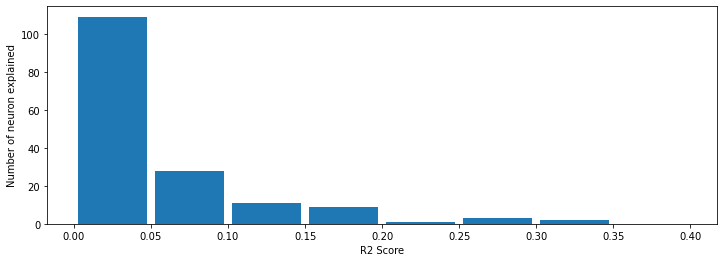

In [25]:
plt.figure(figsize=(12, 4))
plt.hist(np.array([r2 for r2 in r2_dict.values()]), bins=8, range=(0, 0.40), rwidth=0.9)
plt.xlabel("R2 Score")
plt.ylabel("Number of neuron explained")
plt.show()

In [26]:
weight_reliable = []
bias_reliable   = []
key_reliable    = []
for key, value in r2_dict.items():
    if value > 0.10 and value < 0.2:
        wd = weight_dict[key]
        weight_reliable.append([0, 0, wd[0], wd[1]])
        bias_reliable.append(wd[2])
        key_reliable.append(key)

weight_reliable = np.array(weight_reliable)
bias_reliable   = np.array(bias_reliable)
print(len(key_reliable))
print(weight_reliable.shape)
print(bias_reliable.shape)

20
(20, 4)
(20,)


## 卡尔曼滤波器运动解码

In [27]:
from filterpy.kalman import KalmanFilter

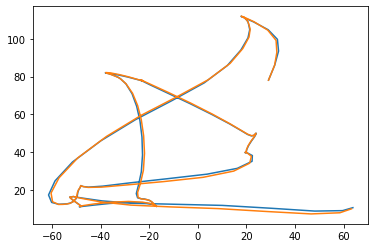

In [584]:
dt = 0.04
itr = 200
start_id = 16000

interval = t[1] - t[0]
i_num = int(dt // interval)

init_x = np.array(
    [cursor_pos[start_id-100:start_id, 0],
     cursor_pos[start_id-100:start_id, 1]]
)

F = np.array(
    [[1, 0],
     [0, 1]]
)
P = np.cov(
    init_x
)
# Q = Q_discrete_white_noise(dim=4, dt=dt, var=1e-3)
Q = np.array(
    [[   1,    0],
     [   0,    1]]
)
R = 1e-1
x = np.array(
    [cursor_pos[start_id, 0],
     cursor_pos[start_id, 1]]
)
H = np.array(
    [[1, 0],
     [0, 1]]
)

# filter
kf = KalmanFilter(dim_x=2, dim_z=2)  # dim_x:隐状态大小，dim_z:量测大小
# 定义参数	 
kf.x = x # 初始状态[位置,速度]
kf.F = F # 状态转移矩阵
kf.H = H  # 量测矩阵
kf.P = P # 初始状态协方差
kf.R = R # 量测噪声
kf.Q = Q # 过程（系统）噪声

filter_result=list()
filter_result.append(x)
for i in range(1, itr):
    z = cursor_pos[start_id + i_num * i]
    kf.predict()
    kf.update(z)
    filter_result.append(kf.x)
filter_result=np.squeeze(np.array(filter_result))

plt.plot(cursor_pos[start_id:start_id+itr*i_num:i_num, 0], cursor_pos[start_id:start_id+itr*i_num:i_num, 1])
plt.plot(filter_result[:, 0], filter_result[:, 1])
plt.show()

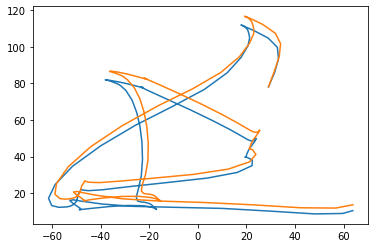

In [573]:
dt = 0.04
itr = 200
start_id = 16000

interval = t[1] - t[0]
i_num = int(dt // interval)

init_x = np.array(
    [cursor_pos[start_id-100:start_id, 0],
     cursor_pos[start_id-100:start_id, 1],
     v[start_id-100:start_id, 0],
     v[start_id-100:start_id, 1],]
)

F = np.array(
    [[1, 0, dt,  0],
     [0, 1,  0, dt],
     [0, 0,  1,  0],
     [0, 0,  0,  1]]
)
P = np.cov(
    init_x
)
# Q = Q_discrete_white_noise(dim=4, dt=dt, var=1e-3)
Q = np.array(
    [[   1,    0,     0,     0],
     [   0,    1,     0,     0],
     [   0,    0,  1e-3,     0],
     [   0,    0,     0,  1e-3]]
)
R = 1e-4
x = np.array(
    [cursor_pos[start_id, 0],
     cursor_pos[start_id, 1],
     v[start_id, 0],
     v[start_id, 1]]
)
H = np.array(
    [[0, 0, 1, 0],
     [0, 0, 0, 1]]
)

# filter
kf = KalmanFilter(dim_x=4, dim_z=2)  # dim_x:隐状态大小，dim_z:量测大小
# 定义参数	 
kf.x = x # 初始状态[位置,速度]
kf.F = F # 状态转移矩阵
kf.H = H  # 量测矩阵
kf.P = P # 初始状态协方差
kf.R = R # 量测噪声
kf.Q = Q # 过程（系统）噪声

filter_result=list()
filter_result.append(x)
for i in range(1, itr):
    z = v[start_id + i_num * i]
    kf.predict()
    kf.update(z)
    filter_result.append(kf.x)
filter_result=np.squeeze(np.array(filter_result))

plt.plot(cursor_pos[start_id:start_id+itr*i_num:i_num, 0], cursor_pos[start_id:start_id+itr*i_num:i_num, 1])
plt.plot(filter_result[:, 0], filter_result[:, 1])
plt.show()

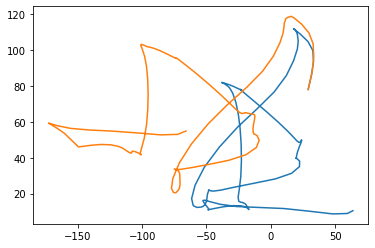

In [593]:
dt = 0.04
itr = 200
start_id = 16000

interval = t[1] - t[0]
i_num = int(dt // interval)

init_x = np.array(
    [cursor_pos[start_id-10:start_id, 0],
     cursor_pos[start_id-10:start_id, 1],
     v[start_id-10:start_id, 0],
     v[start_id-10:start_id, 1],
     a[start_id-10:start_id, 0],
     a[start_id-10:start_id, 1],]
)

F = np.array(
    [[1, 0, dt,  0, 1/2 * dt**2,           0],
     [0, 1,  0, dt,           0, 1/2 * dt**2],
     [0, 0,  1,  0,          dt,           0],
     [0, 0,  0,  1,           0,          dt],
     [0, 0,  0,  0,           1,           0],
     [0, 0,  0,  0,           0,           1]]
)
P = np.cov(
    init_x
)
# Q = Q_discrete_white_noise(dim=4, dt=dt, var=1e-3)
Q = np.array(
    [[   1,    0,     0,     0,    0,    0],
     [   0,    1,     0,     0,    0,    0],
     [   0,    0,     1,     0,    0,    0],
     [   0,    0,     0,     1,    0,    0],
     [   0,    0,     0,     0, 1e-2,    0],
     [   0,    0,     0,     0,    0, 1e-2]]
)
R = 1e-3
x = np.array(
    [cursor_pos[start_id, 0],
     cursor_pos[start_id, 1],
     v[start_id, 0],
     v[start_id, 1],
     a[start_id, 0],
     a[start_id, 1]]
)
H = np.array(
    [[0, 0, 0, 0, 1, 0],
     [0, 0, 0, 0, 0, 1]]
)

# filter
kf = KalmanFilter(dim_x=6, dim_z=2)  # dim_x:隐状态大小，dim_z:量测大小
# 定义参数	 
kf.x = x # 初始状态[位置,速度]
kf.F = F # 状态转移矩阵
kf.H = H # 量测矩阵
kf.P = P # 初始状态协方差
kf.R = R # 量测噪声
kf.Q = Q # 过程（系统）噪声

filter_result=list()
filter_result.append(x)
for i in range(1, itr):
    z = a[start_id + i_num * i]
    kf.predict()
    kf.update(z)
    filter_result.append(kf.x)
filter_result=np.squeeze(np.array(filter_result))

plt.plot(cursor_pos[start_id:start_id+itr*i_num:i_num, 0], cursor_pos[start_id:start_id+itr*i_num:i_num, 1])
plt.plot(filter_result[:, 0], filter_result[:, 1])
plt.show()

现在发现我们并不能得到很好的估计，尝试直接拟合一个更好的量测矩阵H；

In [28]:
dt = 0.04
itr = 2
start_id = 1000

interval = t[1] - t[0]
i_num = int(dt // interval)

In [29]:
def get_measured_firing_rate(keys, time_t):
    sigma = 1.0
    frs = []
    for channel_id, unit_id in keys:
        spikes = np.array(data[data['spikes'][unit_id, channel_id]]).transpose(1, 0)
        fr = extract_spikes(spikes, time_t, range=[-0.5, 0.5]) - time_t
        fr_kernel = np.exp(- fr ** 2 / 2 / sigma ** 2)
        frs.append(np.sum(fr_kernel))
    return np.array(frs)

In [32]:
x_sampled = []
frs_sampled = []
for i in range(1, 100):
    frs_sampled.append(get_measured_firing_rate(key_reliable, t[start_id + i_num * i]))
    x_sampled.append([cursor_pos[start_id + i_num * i, 0], cursor_pos[start_id + i_num * i, 1], v[start_id + i_num * i, 0], v[start_id + i_num * i, 1]])
frs_sampled = np.array(frs_sampled)
x_sampled = np.array(x_sampled)

In [33]:
model = LinearRegression()
model.fit(x_sampled, frs_sampled)
frs_pred = model.predict(x_sampled)
r2_score(frs_sampled, frs_pred)

0.49834147575796833

[[ 1.00000000e+00  1.55083974e-14  4.00000000e-03  4.18696174e-15]
 [-1.42937923e-13  1.00000000e+00  1.87457571e-14  4.00000000e-03]
 [-2.31224045e-01  7.58754792e-02  9.73781959e-01 -1.40798443e-02]
 [ 5.28032970e-01 -1.67635776e-01  5.69669024e-02  1.00745563e+00]]


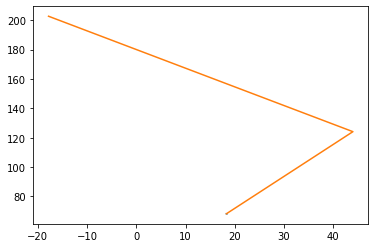

In [43]:
itr = 3

init_x = np.array(
    [cursor_pos[start_id-100:start_id+100, 0],
     cursor_pos[start_id-100:start_id+100, 1],
     v[start_id-100:start_id+100, 0],
     v[start_id-100:start_id+100, 1],]
)

X2 = init_x[:, 1:  ]
X1 = init_x[:,  :-1]
F = X2 @ X1.T @ np.linalg.inv(X1 @ X1.T) # Transition matrix
print(F)

# F = np.array(
#     [[  1,  0, dt,  0],
#      [  0,  1,  0, dt],
#      [  0,  0,  1,  0],
#      [  0,  0,  0,  1]]
# )
P = np.cov(
    init_x
)
# Q = Q_discrete_white_noise(dim=4, dt=dt, var=1e-3)
Q = np.cov(X2 - F @ X1)
R = 10
x = np.array(
    [cursor_pos[start_id, 0],
     cursor_pos[start_id, 1],
     v[start_id, 0],
     v[start_id, 1]]
)
# H = weight_reliable
H = model.coef_
# H = Z @ X.T @ (np.linalg.inv(X @ X.T)) # Measurement matrix

# filter
kf = KalmanFilter(dim_x=4, dim_z=len(key_reliable))  # dim_x:隐状态大小，dim_z:量测大小
# 定义参数	 
kf.x = x # 初始状态[位置,速度]
kf.F = F # 状态转移矩阵
kf.H = H  # 量测矩阵
kf.P = P # 初始状态协方差
kf.R = R # 量测噪声
kf.Q = Q # 过程（系统）噪声

filter_result=list()
filter_result.append(x)
for i in range(1, itr):
    z = get_measured_firing_rate(key_reliable, t[start_id + i_num * i]) - model.intercept_
    kf.predict()
    kf.update(z)
    filter_result.append(kf.x)
filter_result=np.squeeze(np.array(filter_result))

plt.plot(cursor_pos[start_id:start_id+itr, 0], cursor_pos[start_id:start_id+itr, 1])
plt.plot(filter_result[:, 0], filter_result[:, 1])
plt.show()

最后，我们尝试一下简单的线性回归模型

In [312]:
x_sampled = []
frs_sampled = []
for i in range(1, 100):
    frs_sampled.append(get_measured_firing_rate(key_reliable, t[start_id + 25 * i]))
    x_sampled.append([cursor_pos[start_id + 25 * i, 0], cursor_pos[start_id + 25 * i, 1], v[start_id + 25 * i, 0], v[start_id + 25 * i, 1]])
frs_sampled = np.array(frs_sampled)
x_sampled = np.array(x_sampled)

In [313]:
model = LinearRegression()
model.fit(frs_sampled, x_sampled)
x_pred = model.predict(frs_sampled)
r2_score(x_sampled, x_pred)

0.6625346854142011

In [314]:
x_pred[:, 1]

array([ 89.18566974,  75.84265467,  66.79943306,  69.0151483 ,
        64.33298682,  52.33952743,  33.36850444,  26.64377592,
        27.5318469 ,  32.5663734 ,  26.79012817,  36.51413899,
        32.55651891,  34.43974284,  33.34733597,  33.75508828,
        50.10194804,  41.60145366,  38.42065607,  46.05783544,
        52.76776372,  58.12848204,  77.0788073 ,  73.33127615,
        79.82949751,  90.22177059,  76.85562022,  99.03229522,
       106.27206759, 105.51958328, 100.18968074,  94.2600365 ,
        81.91576195,  83.08314087,  70.6712632 ,  73.39203087,
        84.4315381 ,  79.36081404,  76.98323298,  74.804716  ,
        73.40052412,  81.06109749,  86.56948576,  81.78651612,
        85.95597036,  84.16640416,  73.83045613,  78.37433406,
        86.65984644,  85.41173717,  91.22824962,  79.08759077,
        83.93269792,  89.86180156,  90.39389192,  86.91670673,
       110.33196138,  94.51532013,  86.80001084,  81.6309819 ,
        83.94271574,  77.22599306,  63.54641275,  67.63

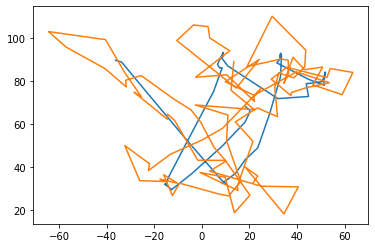

In [315]:
plt.plot(cursor_pos[start_id:start_id+2000:25, 0], cursor_pos[start_id:start_id+2000:25, 1])
plt.plot(x_pred[:, 0], x_pred[:, 1])
plt.show()

## 附录

可以考虑使用速度来计算Tuning Curve

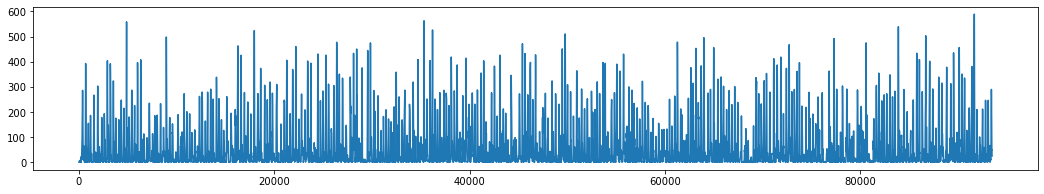

In [78]:
plt.figure(figsize=(18, 3))
speed = np.linalg.norm(v, ord=2, axis=1)
plt.plot(np.arange(speed.shape[0]), speed)

In [20]:
from scipy import signal

In [21]:
peak_indexes = signal.argrelextrema(speed, np.greater, axis=0, order=100)[0]

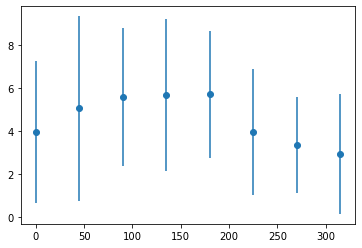

In [24]:
degree_fire = {}
for i in range(len(peak_indexes)):
    # 对所有事件循环，计算一段时间的位移方向
    # pos_diff = cursor_pos[event_index[i+1]] - cursor_pos[event_index[i]]
    # pos_diff = target_pos[event_index[i]] - target_pos[event_index[i] - 1]
    pos_diff = v[peak_indexes[i]]
    degree = int(np.floor(compute_degree(pos_diff) / 45 + 0.5)) * 45
    if degree == 360:
        degree = 0

    # 计算这段区间内的Firing Rate
    tmp = degree_fire.get(degree, [])
    tmp.append(len(extract_spikes(spikes, t[peak_indexes[i]], [-0.3, 0.3])) / 0.6)
    degree_fire[degree] = tmp

x = []
y = []
std = []
for degree in degree_fire:
    x.append(degree)
    y.append(np.mean(degree_fire[degree]))
    std.append(np.std(degree_fire[degree]))

x = np.array(x)
y = np.array(y)
std = np.array(std)

plt.vlines(x, y-std, y+std)
plt.scatter(x, y)